In [25]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [54]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 9,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 16,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

# Load data

In [55]:
def split_data_time_over(period, cfg):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    num_data_points = len(df)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)

    data_travel_time = [float(df.loc[df.index == date]['delta_t']) for date in df.index]
    data_travel_time = np.array(data_travel_time)

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        tmp_time = pd.Series(time[part_time_idx], name='datetime')
        tmp_travel_time = pd.Series(travel_time[part_time_idx], name='travel_time')
        df = pd.concat([tmp_time, tmp_travel_time], axis=1)
        df = df.set_index('datetime')

        num_data_points_list.append(len(df))
        df_list.append(df)

    return df_list, num_data_points_list

In [56]:
df, num_data_points_list = split_data_time_over(3, cfg)

# Data preparation: normalize raw data

In [67]:
class Normalizer:
    def __init__(self):
        self.normalize_data = None
        self.std_data = 0
        self.mean_data = 0
        self.std_diff = None

    def fit_transform(self, data):
        # normalize
        self.mean_data, self.std_data = data.mean(), data.std()
        self.normalize_data = (data - self.mean_data) / self.std_data
        
        # first difference
        diff_data = self.normalize_data.diff().fillna(self.normalize_data)
        # diff_data = self.normalize_data.diff().dropna()
        
        # remove increasing volatility
        self.std_diff = diff_data.groupby(diff_data.index.hour).std()
        data_hourly_volatility = diff_data.index.map(lambda d: self.std_diff.loc[d.hour])

        remove_data = diff_data / data_hourly_volatility

        return remove_data

    def inverse_transform(self, data, split_data_index=0):
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            if (idx + split_data_index) == 0:
                _data = (self.std_data * (self.std_diff[data.index[idx].hour] * data[idx])) + self.mean_data
            else:
                _data = (self.std_data * ((self.std_diff[data.index[idx].hour] * data[idx]) + self.normalize_data[(idx - 1) + split_data_index])) + self.mean_data
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series

In [68]:
scaler_list = [Normalizer() for _ in range(len(df))]
normalize_data_list = [scaler_list[idx].fit_transform(df[idx]['travel_time']) for idx in range(len(df))]

# Data preparation: generating training, test and validation data

In [69]:
def preprocess(data, window_size):
    X, y, y_date = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i].to_list())
        y.append(data[i])
        y_date.append(data.index[i])
    return np.array(X), np.array(y), np.array(y_date)

def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
    data_x, data_y, data_date_y = preprocess(normalize_data, cfg['data']['window_size'])
    
    # init split index
    split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data x
    data_x_train = data_x[:split_train_index]
    data_x_val = data_x[split_train_index:split_val_index]
    data_x_test = data_x[split_val_index:]

    # split data y
    data_y_train = data_y[:split_train_index]
    data_date_y_train = data_date_y[:split_train_index]
    data_y_val = data_y[split_train_index:split_val_index]
    data_date_y_val = data_date_y[split_train_index:split_val_index]
    data_y_test = data_y[split_val_index:]
    data_date_y_test = data_date_y[split_val_index:]

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)
        

        data_y_train_series = pd.Series(data_y_train, index=data_date_y_train)
        data_y_val_series = pd.Series(data_y_val, index=data_date_y_val)
        data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)


        to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train_series, cfg['data']['window_size'])
        to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val_series, split_train_index + cfg['data']['window_size'])
        to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, split_val_index + cfg['data']['window_size'])

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        idx = np.arange(0, len(normalize_data))

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(idx, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, split_train_index, split_val_index


In [70]:
# def preprocess(data, window_size):
#     X, y, y_date = [], [], []
#     for i in range(window_size, len(data)):
#         X.append(data[i - window_size:i].to_list())
#         y.append(data[i])
#         y_date.append(data.index[i])
#     return np.array(X), np.array(y), np.array(y_date)

# def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
#     data_x, data_y, data_date_y = preprocess(normalize_data, cfg['data']['window_size'])
    
#     # init split index
#     split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
#     split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

#     # split data for train test model
#     # split data x
#     data_x_train = data_x[:split_train_index]
#     data_x_val = data_x[split_train_index:split_val_index]
#     data_x_test = data_x[split_val_index:]

#     # split data y
#     data_y_train = data_y[:split_train_index]
#     data_date_y_train = data_date_y[:split_train_index]
#     data_y_val = data_y[split_train_index:split_val_index]
#     data_date_y_val = data_date_y[split_train_index:split_val_index]
#     data_y_test = data_y[split_val_index:]
#     data_date_y_test = data_date_y[split_val_index:]

#     if plot:
#         road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
#         path = cfg['data']['path'].split('/')[-2]

#         to_plot_data_y_train = np.zeros(num_data_points)
#         to_plot_data_y_val = np.zeros(num_data_points)
#         to_plot_data_y_test = np.zeros(num_data_points)
        

#         data_y_train_series = pd.Series(data_y_train, index=data_date_y_train)
#         data_y_val_series = pd.Series(data_y_val, index=data_date_y_val)
#         data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)


#         to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train_series, cfg['data']['window_size'])
#         to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val_series, split_train_index + cfg['data']['window_size'])
#         to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, split_val_index + cfg['data']['window_size'])

#         to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
#         to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
#         to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

#         idx = np.arange(0, len(normalize_data))

#         # plot
#         fig = plt.figure(figsize=(25, 5), dpi=80)
#         fig.patch.set_facecolor((1.0, 1.0, 1.0))
#         plt.plot(idx, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
#         plt.plot(idx, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
#         plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

#         plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
#         plt.grid(b=None, which='major', axis='y', linestyle='--')
#         plt.legend()
#         plt.show()

#     return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, split_train_index, split_val_index

# Data preparation: generating training, test and validation data

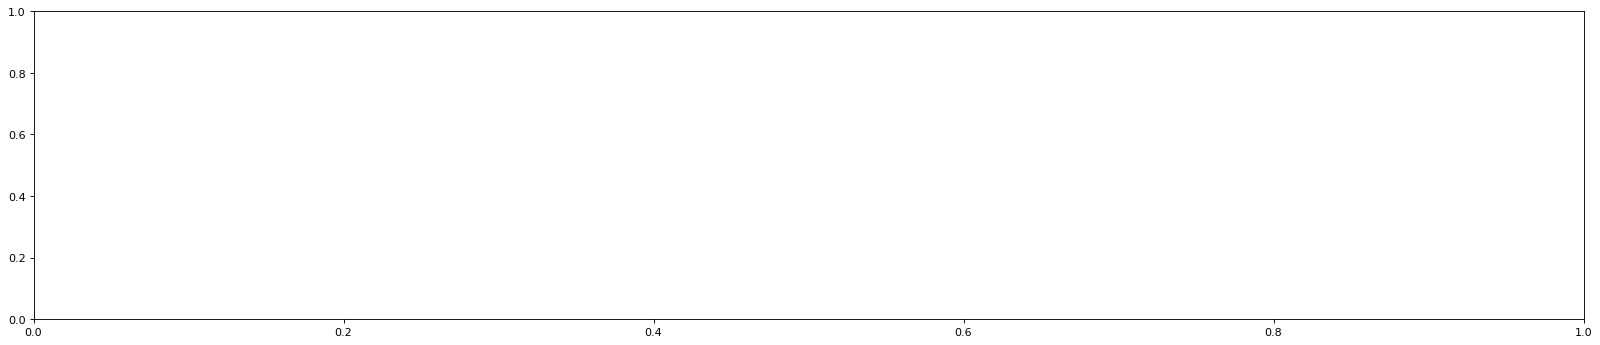

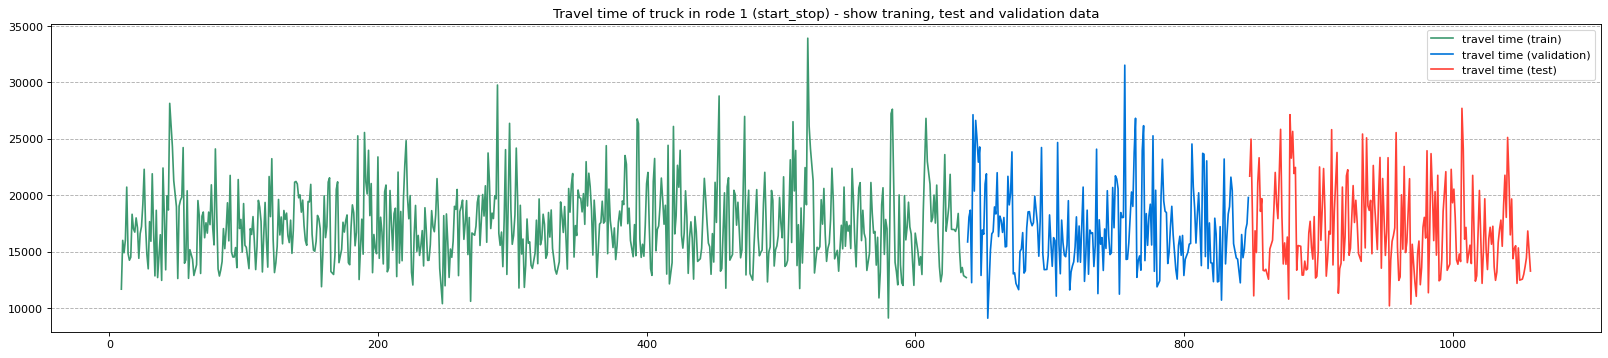

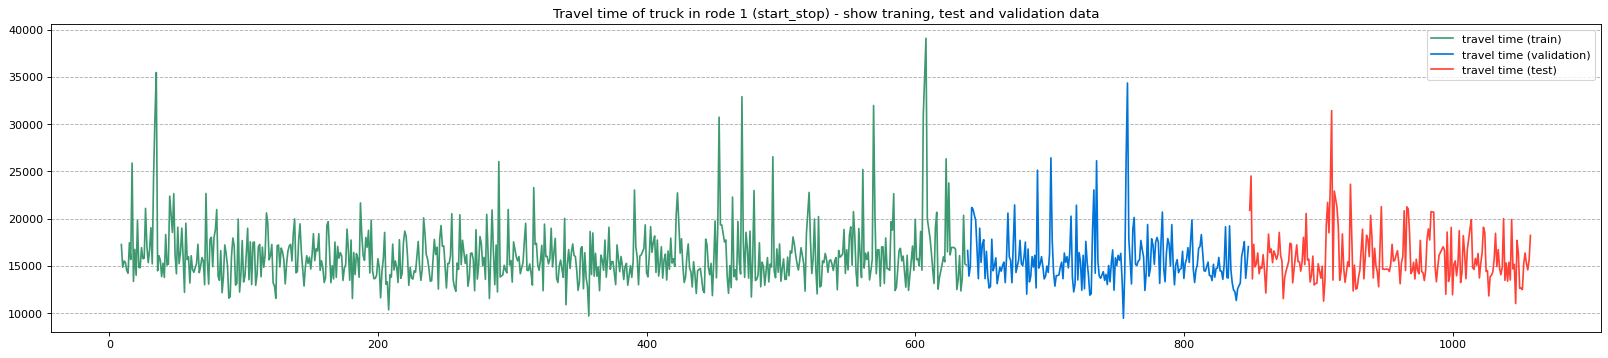

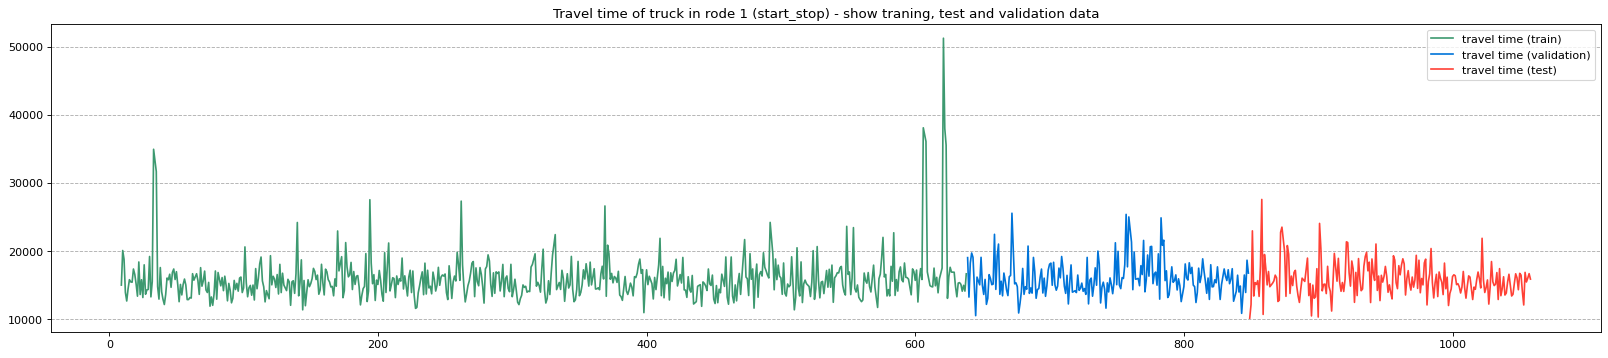

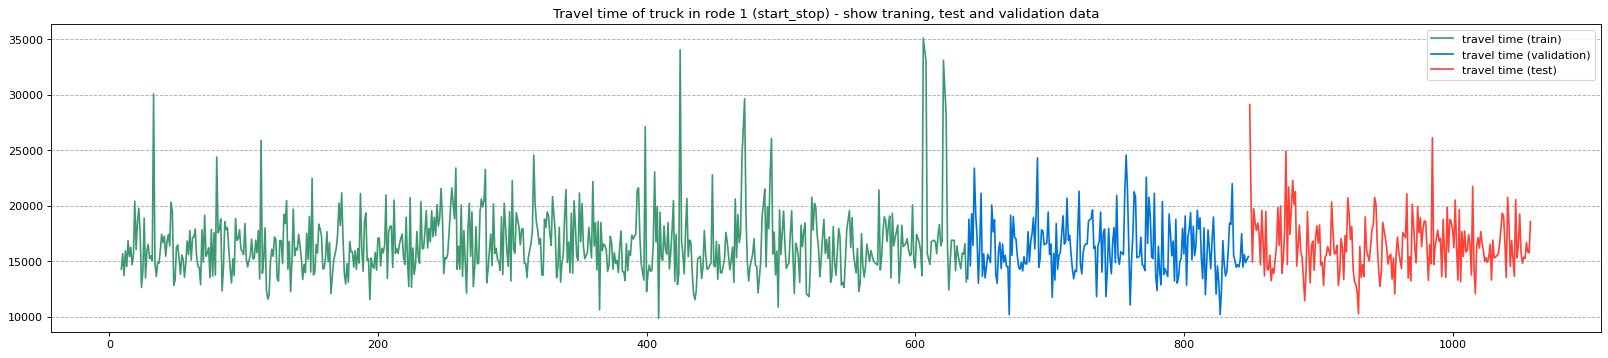

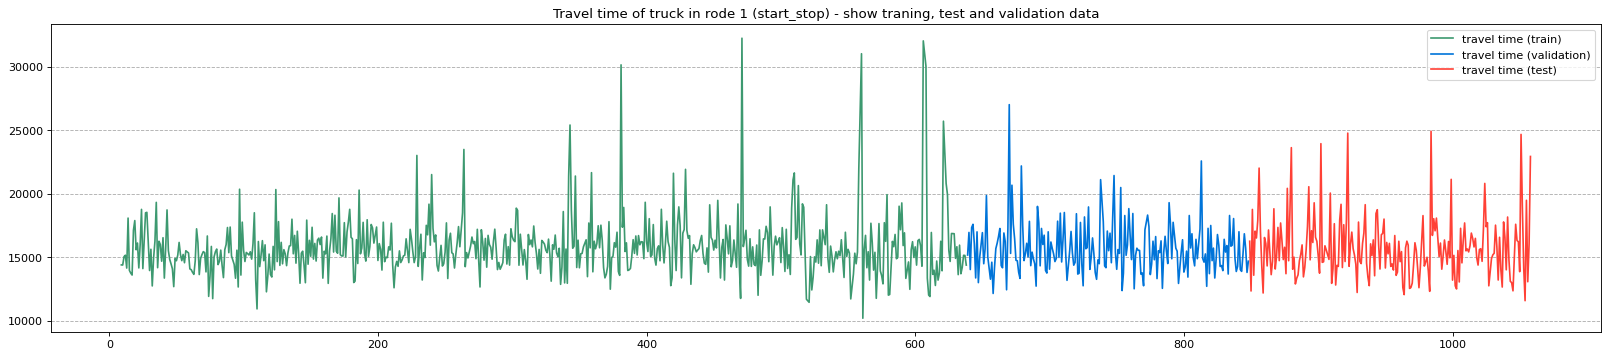

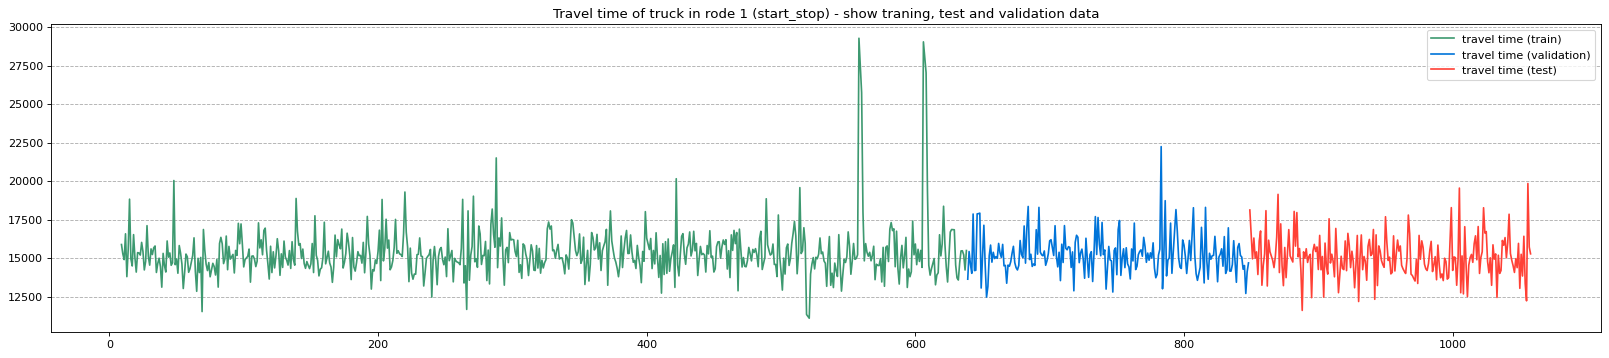

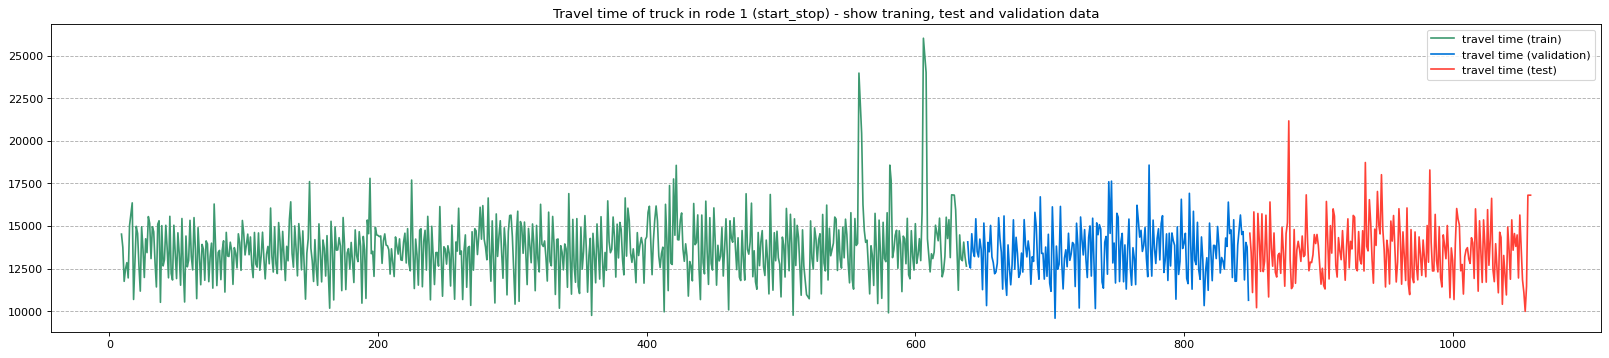

In [71]:
data_x_train_list, data_x_val_list, data_x_test_list, data_y_train_list, data_y_val_list, data_y_test_list, data_date_y_test_list, split_val_index_list = [], [], [], [], [], [], [], []
for idx in range(len(normalize_data_list)):
    data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, data_date_y_test, _, split_val_index = generate_train_test_val(normalize_data_list[idx], num_data_points_list[idx], scaler_list[idx], cfg, True)
    data_x_train_list.append(data_x_train)
    data_x_val_list.append(data_x_val)
    data_x_test_list.append(data_x_test)
    data_y_train_list.append(data_y_train)
    data_y_val_list.append(data_y_val)
    data_y_test_list.append(data_y_test)
    data_date_y_test_list.append(data_date_y_test)
    split_val_index_list.append(split_val_index)

In [72]:
for idx in range(len(data_x_train_list)):
    print(f"time: {idx}")
    print(f"Train data shape: {data_x_train_list[idx].shape} {data_y_train_list[idx].shape}")
    print(f"Validation data shape: {data_x_val_list[idx].shape} {data_y_val_list[idx].shape}")
    print(f"Test data shape: {data_x_test_list[idx].shape} {data_y_test_list[idx].shape}")

time: 0
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 1
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 2
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 3
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 4
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 5
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)
time: 6
Train data shape: (630, 9) (630,)
Validation data shape: (210, 9) (210,)
Test data shape: (210, 9) (210,)


In [73]:
dataset_train, dataset_val, dataset_test = [], [], []
for idx in range(len(data_x_train_list)):
    dataset_train.append(TravelTimeDataset(data_x_train_list[idx], data_y_train_list[idx]))
    dataset_val.append(TravelTimeDataset(data_x_val_list[idx], data_y_val_list[idx]))
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Train data for model shape: {dataset_train[idx].x.shape} {dataset_train[idx].y.shape}")
    print(f"Validation data for model shape: {dataset_val[idx].x.shape} {dataset_val[idx].y.shape}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 1
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 2
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 3
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 4
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 5
Train data for model shape: (630, 1, 9) (630,)
Validation data for model shape: (210, 1, 9) (210,)
Test data for model shape: (210, 1, 9) (210,)
time : 6
Train data for model shape: (630, 1, 9) (630,)
Validation data for 

# Define CNN-LSTM model

In [74]:
class CNN_Block(nn.Module):
    def __init__(self):
        super(CNN_Block, self).__init__()
        self.conv_1_out = [32, 64, 128]
        self.conv_2_out = [32, 64, 128]
        self.conv_kernel_size = [2, 3]

        self.conv_1 = nn.Conv1d(1, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_2 = nn.Conv1d(64, 128, kernel_size=self.conv_kernel_size[0], stride=1)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        out = self.maxpool_1(out)

        return out

In [75]:
class LSTM_Block(nn.Module):
    def __init__(self):
        super(LSTM_Block, self).__init__()
        self.lstm_in = [32, 64, 128]
        self.lstm_hidden = [64, 128, 200, 256]
        self.linear_out = [32, 64]
        self.dropout = [0.1, 0.2, 0.3]

        self.lstm_1 = nn.LSTM(
            input_size=128,
            hidden_size=200,
            num_layers=1,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(200, 32)
        self.dropout_1 = nn.Dropout(0.5)

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out[:, -1, :]
        out = F.relu(self.fc_1(out))
        out = self.dropout_1(out)

        return out

In [76]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.linear_in = [32, 64]
        self.cnn_block = CNN_Block()
        self.lstm_block = LSTM_Block()
        self.out_block = nn.Linear(32, 1)

    def forward(self, x):
        # CNN block
        out = self.cnn_block(x)

        # print(out.shape)

        out = out.view(out.shape[0], out.shape[2], out.shape[1])

        # print(out.shape)
        # LSTM block
        out = self.lstm_block(out)
        
        # Output layer
        out = self.out_block(out)

        return out

In [77]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [78]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model training

In [79]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

# Model evaluation

In [80]:
def eval(dataset_test, data_date_y_test, split_val_index, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    # print(dataset_test.y)
    # print(data_date_y_test.shape)

    data_test_y_series = pd.Series(dataset_test.y, index=data_date_y_test)
    predict_test_series = pd.Series(predicted_test, index=data_date_y_test)

    # print(data_test_y_series)



    # print(predict_test_series)

    mse = mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])))
    mae = mean_absolute_error(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']), scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))

    # print(f"MSE : {mse}")
    # print(f"RMSE : {rmse}")
    # print(f"MAE : {mae}")
    print(scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size']))
    print(scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size']))

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(data_test_y_series, split_val_index + cfg['data']['window_size'])
        to_plot_predicted_test = scaler.inverse_transform(predict_test_series, split_val_index + cfg['data']['window_size'])

        idx = np.arange(0, len(data_date_y_test))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

# Modified

2019-10-23 00:00:00    21695.000000
2019-10-23 01:00:00    24980.333333
2019-10-23 02:00:00    18392.000000
2019-10-24 00:00:00    11090.000000
2019-10-24 01:00:00    16855.000000
                           ...     
2019-12-30 01:00:00    13661.000000
2019-12-30 02:00:00    14449.500000
2019-12-31 00:00:00    16838.000000
2019-12-31 01:00:00    15060.500000
2019-12-31 02:00:00    13283.000000
Length: 210, dtype: float64
2019-10-23 00:00:00    16514.576723
2019-10-23 01:00:00    17704.940233
2019-10-23 02:00:00    19473.305874
2019-10-24 00:00:00    16809.700200
2019-10-24 01:00:00    13558.511750
                           ...     
2019-12-30 01:00:00    14378.499985
2019-12-30 02:00:00    14189.418002
2019-12-31 00:00:00    14324.110778
2019-12-31 01:00:00    15027.716449
2019-12-31 02:00:00    14245.732615
Length: 210, dtype: float64


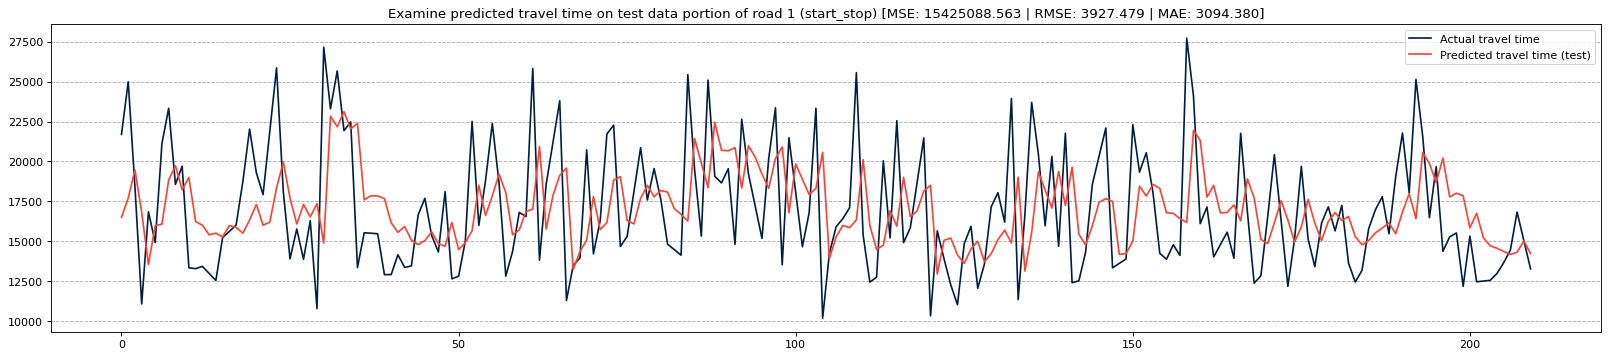

time : 0
MSE : 15425088.563253412 || RMSE : 3927.4786521702968 || MAE : 3094.3797959112053
2019-10-23 03:00:00    20884.000000
2019-10-23 04:00:00    24513.000000
2019-10-23 05:00:00    13620.333333
2019-10-24 03:00:00    17282.000000
2019-10-24 04:00:00    14896.000000
                           ...     
2019-12-30 04:00:00    16359.000000
2019-12-30 05:00:00    15279.000000
2019-12-31 03:00:00    14573.000000
2019-12-31 04:00:00    15617.333333
2019-12-31 05:00:00    18222.000000
Length: 210, dtype: float64
2019-10-23 03:00:00    14144.962289
2019-10-23 04:00:00    17173.465409
2019-10-23 05:00:00    19853.567055
2019-10-24 03:00:00    14308.549557
2019-10-24 04:00:00    15500.095673
                           ...     
2019-12-30 04:00:00    14630.226865
2019-12-30 05:00:00    14714.479257
2019-12-31 03:00:00    14725.618253
2019-12-31 04:00:00    14614.091552
2019-12-31 05:00:00    15322.925013
Length: 210, dtype: float64


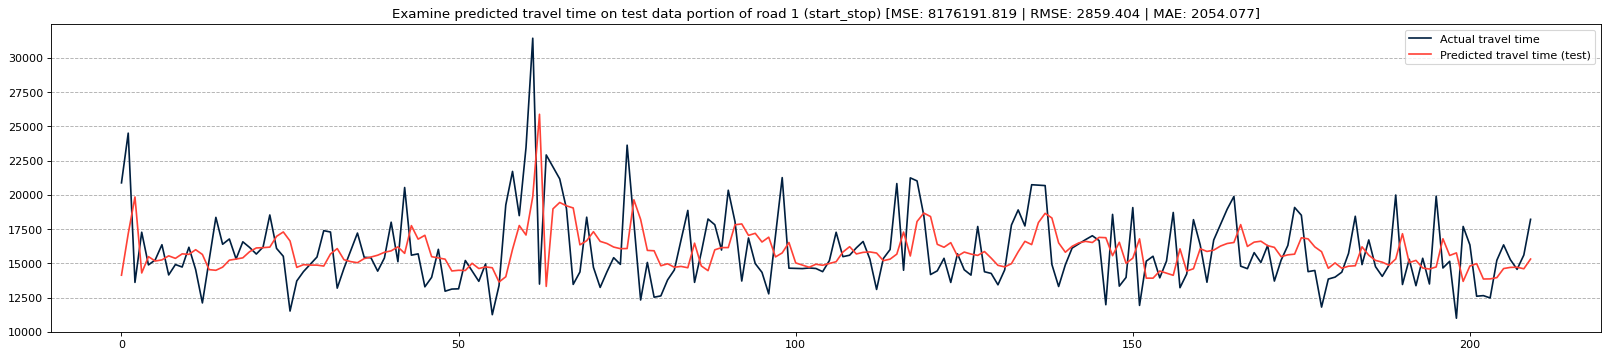

time : 1
MSE : 8176191.819009683 || RMSE : 2859.404102083104 || MAE : 2054.077038225854
2019-10-23 06:00:00    10168.00
2019-10-23 07:00:00    12173.00
2019-10-23 08:00:00    22975.00
2019-10-24 06:00:00    13419.50
2019-10-24 07:00:00    15382.25
                         ...   
2019-12-30 07:00:00    16893.50
2019-12-30 08:00:00    15480.00
2019-12-31 06:00:00    16037.00
2019-12-31 07:00:00    16705.00
2019-12-31 08:00:00    15903.50
Length: 210, dtype: float64
2019-10-23 06:00:00    15310.587547
2019-10-23 07:00:00    11575.773398
2019-10-23 08:00:00    12084.750287
2019-10-24 06:00:00    16247.854860
2019-10-24 07:00:00    12319.264449
                           ...     
2019-12-30 07:00:00    14429.363477
2019-12-30 08:00:00    15350.566117
2019-12-31 06:00:00    15421.406810
2019-12-31 07:00:00    15984.758878
2019-12-31 08:00:00    16472.492387
Length: 210, dtype: float64


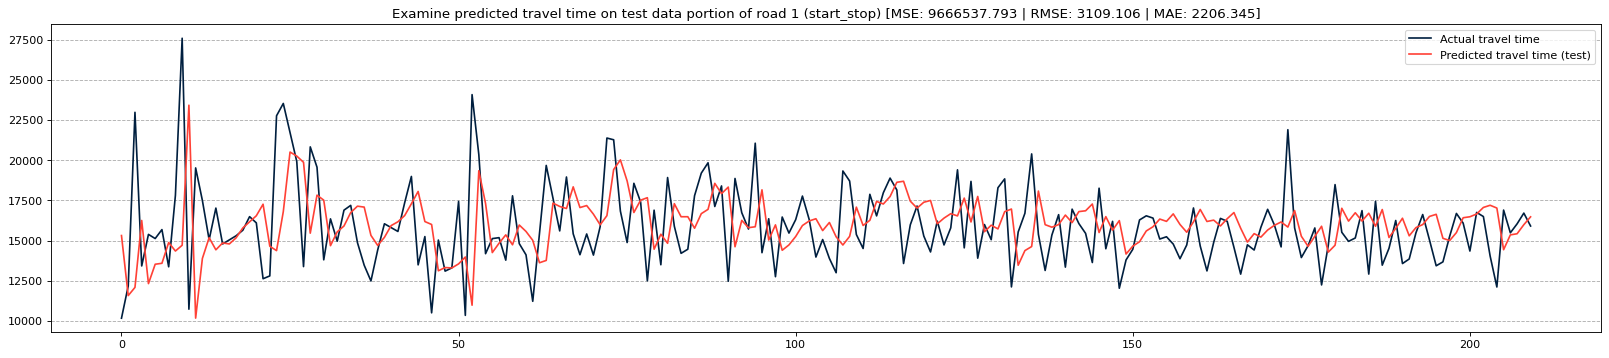

time : 2
MSE : 9666537.79275633 || RMSE : 3109.105625860326 || MAE : 2206.3448816786977
2019-10-23 09:00:00    29102.500000
2019-10-23 10:00:00    20669.333333
2019-10-23 11:00:00    14898.000000
2019-10-24 09:00:00    19731.000000
2019-10-24 10:00:00    18455.000000
                           ...     
2019-12-30 10:00:00    15247.500000
2019-12-30 11:00:00    16693.500000
2019-12-31 09:00:00    15829.916667
2019-12-31 10:00:00    15756.333333
2019-12-31 11:00:00    18565.000000
Length: 210, dtype: float64
2019-10-23 09:00:00    16380.895053
2019-10-23 10:00:00    23104.508742
2019-10-23 11:00:00    21188.334451
2019-10-24 09:00:00    17928.922685
2019-10-24 10:00:00    18607.951168
                           ...     
2019-12-30 10:00:00    16938.353876
2019-12-30 11:00:00    16838.528178
2019-12-31 09:00:00    16948.743230
2019-12-31 10:00:00    17200.441749
2019-12-31 11:00:00    16871.045003
Length: 210, dtype: float64


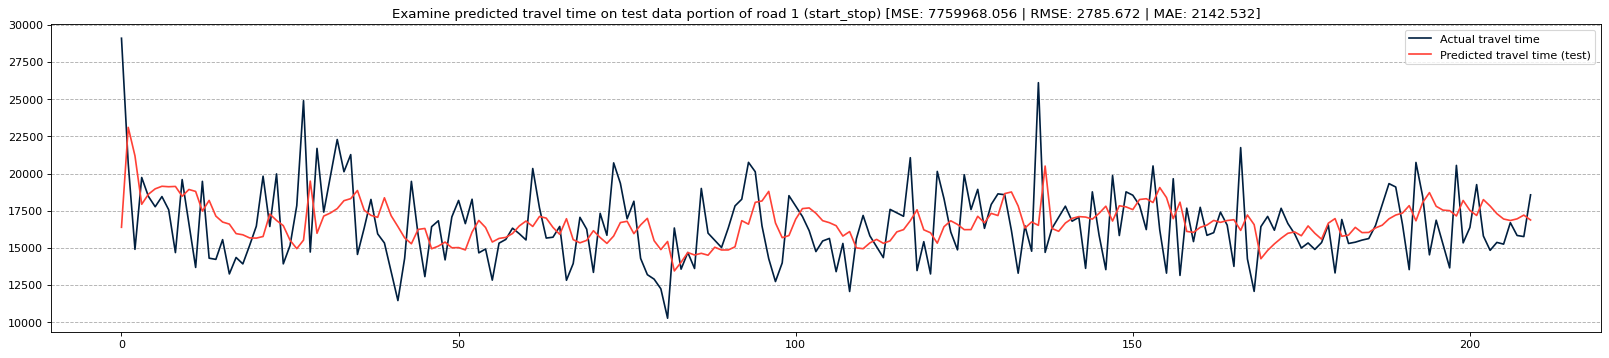

time : 3
MSE : 7759968.056385231 || RMSE : 2785.6719218862136 || MAE : 2142.5321447324286
2019-10-23 12:00:00    16266.000000
2019-10-23 13:00:00    12344.500000
2019-10-23 14:00:00    18771.166667
2019-10-24 12:00:00    13587.000000
2019-10-24 13:00:00    17063.500000
                           ...     
2019-12-30 13:00:00    11580.000000
2019-12-30 14:00:00    19490.000000
2019-12-31 12:00:00    13074.000000
2019-12-31 13:00:00    16082.000000
2019-12-31 14:00:00    22946.000000
Length: 210, dtype: float64
2019-10-23 12:00:00    14649.940560
2019-10-23 13:00:00    15263.391056
2019-10-23 14:00:00    13942.125318
2019-10-24 12:00:00    14381.939114
2019-10-24 13:00:00    13693.345039
                           ...     
2019-12-30 13:00:00    15985.971440
2019-12-30 14:00:00    13482.908210
2019-12-31 12:00:00    15437.213390
2019-12-31 13:00:00    13572.946531
2019-12-31 14:00:00    14474.222330
Length: 210, dtype: float64


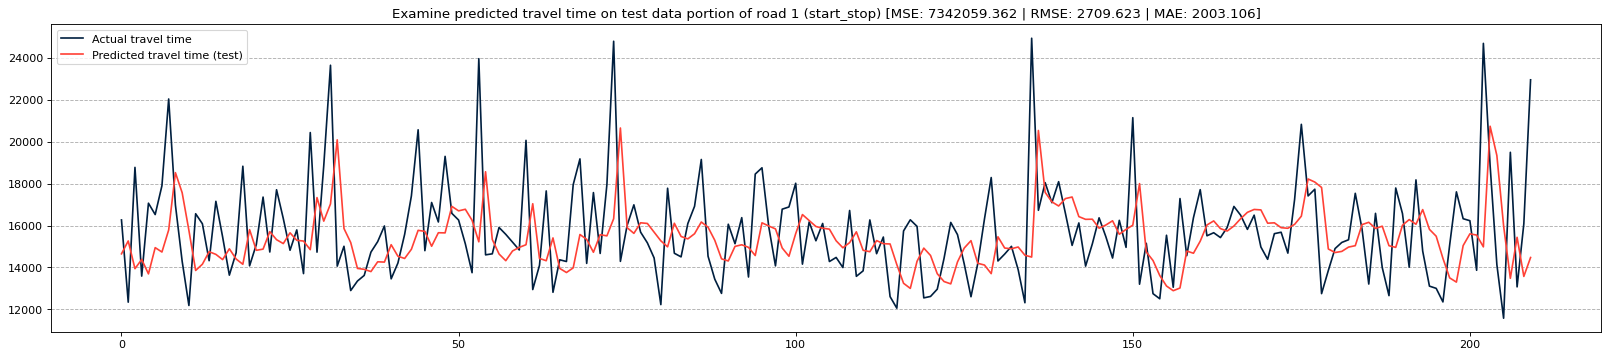

time : 4
MSE : 7342059.362193528 || RMSE : 2709.6234724023057 || MAE : 2003.1062428897155
2019-10-23 15:00:00    18117.833333
2019-10-23 16:00:00    16513.166667
2019-10-23 17:00:00    14944.000000
2019-10-24 15:00:00    16299.500000
2019-10-24 16:00:00    14997.250000
                           ...     
2019-12-30 16:00:00    13337.333333
2019-12-30 17:00:00    12219.888889
2019-12-31 15:00:00    19838.000000
2019-12-31 16:00:00    15715.250000
2019-12-31 17:00:00    15271.666667
Length: 210, dtype: float64
2019-10-23 15:00:00    14336.706508
2019-10-23 16:00:00    15863.906797
2019-10-23 17:00:00    15839.873392
2019-10-24 15:00:00    15452.661956
2019-10-24 16:00:00    15991.853020
                           ...     
2019-12-30 16:00:00    15418.873649
2019-12-30 17:00:00    14118.111101
2019-12-31 15:00:00    13836.408797
2019-12-31 16:00:00    17505.543021
2019-12-31 17:00:00    15841.387475
Length: 210, dtype: float64


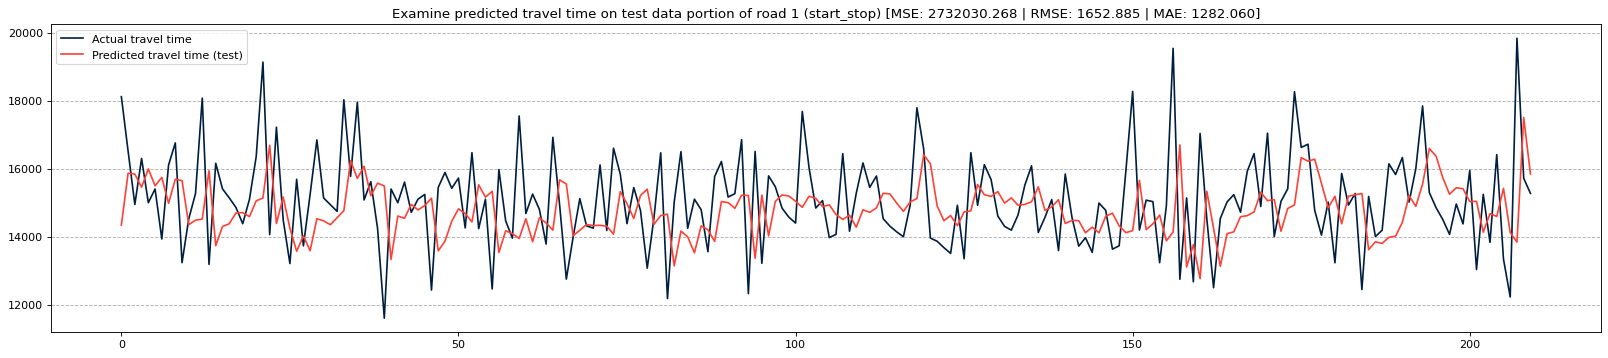

time : 5
MSE : 2732030.268433184 || RMSE : 1652.885437177418 || MAE : 1282.0597271070692
2019-10-23 18:00:00    14571.714286
2019-10-23 19:00:00    13445.166667
2019-10-23 20:00:00    11091.000000
2019-10-24 18:00:00    15825.500000
2019-10-24 19:00:00    12937.200000
                           ...     
2019-12-30 19:00:00     9985.000000
2019-12-30 20:00:00    11465.000000
2019-12-31 18:00:00    16805.000000
2019-12-31 19:00:00    16805.000000
2019-12-31 20:00:00    16805.000000
Length: 210, dtype: float64
2019-10-23 18:00:00    12907.838706
2019-10-23 19:00:00    13134.374678
2019-10-23 20:00:00    12962.156168
2019-10-24 18:00:00    13309.182136
2019-10-24 19:00:00    13896.868459
                           ...     
2019-12-30 19:00:00    12575.752559
2019-12-30 20:00:00    12509.054412
2019-12-31 18:00:00    11282.350166
2019-12-31 19:00:00    14298.605280
2019-12-31 20:00:00    14142.173760
Length: 210, dtype: float64


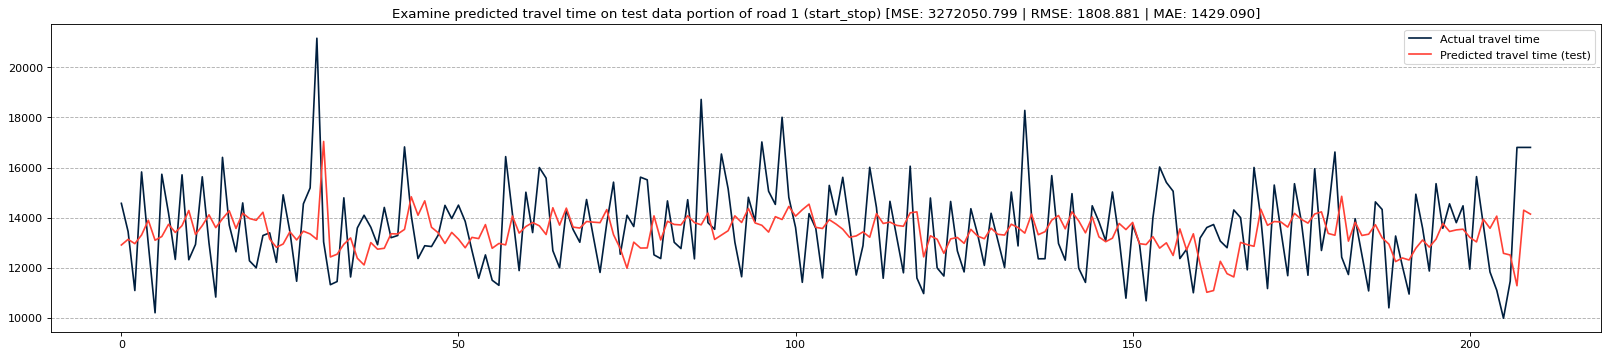

time : 6
MSE : 3272050.7993910345 || RMSE : 1808.8810904509546 || MAE : 1429.0900173264765


In [81]:
result = []
for idx in range(len(dataset_train)):
    model = LSTM()
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train[idx], dataset_val[idx], model, cfg, idx, 0)

    mse, rmse, mae = eval(dataset_test[idx], data_date_y_test_list[idx], split_val_index_list[idx], scaler_list[idx], model, cfg, f"cnn_lstm_time_{idx}_{0}", True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
    })

In [ ]:
df[0]

,travel_time
datetime,
2019-01-01 00:00:00,15034.000000
2019-01-01 01:00:00,17934.000000
2019-01-01 02:00:00,17211.333333
2019-01-02 00:00:00,13053.000000
2019-01-02 01:00:00,14023.333333
...,...
2019-12-30 01:00:00,13661.000000
2019-12-30 02:00:00,14449.500000
2019-12-31 00:00:00,16838.000000
